# Earthquake seismology with DAS

Figure 5 from Ajo-Franklin et al 2019:
https://www.nature.com/articles/s41598-018-36675-8

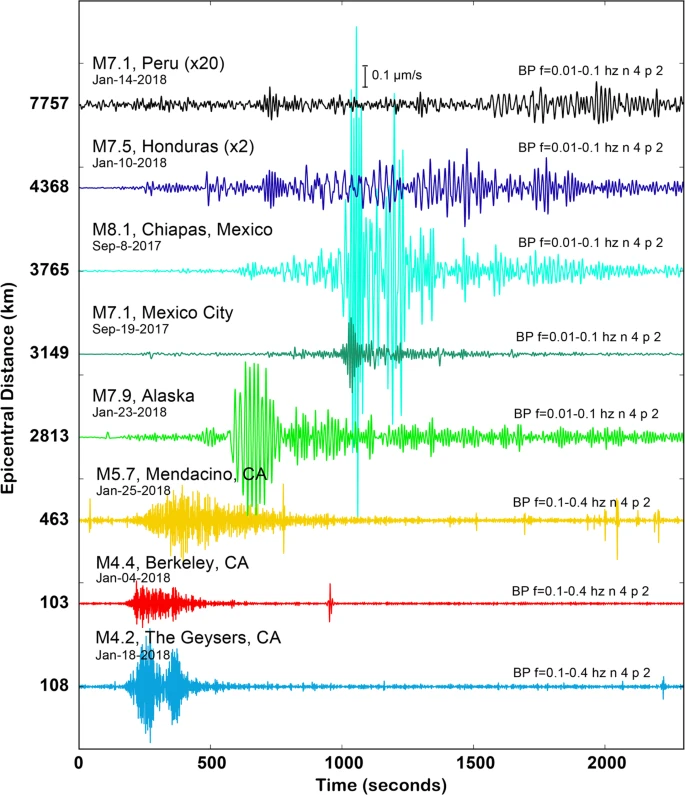

In [1]:
import h5py
import matplotlib.pyplot as plt
# %matplotlib notebook
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.dates as mdates
import datetime

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

pth ='/data/data0/seadasn/'
title=''

# Default filter parameters: Good for teleseisms
low_cut = 0.05
hi_cut = 1

# M 6.7 - 58 km WSW of Masachapa, Nicaragua
### 2022-04-21 07:42:46 (UTC)11.554°N 86.992°W25.3 km depth

http://ds.iris.edu/wilber3/find_stations/11552089
https://earthquake.usgs.gov/earthquakes/eventpage/us6000hf75/executive

In [2]:
title = 'mww6.7 Near Coast Of Nicaragua'
file_base_name = 'seadasn'
sample_rate = 100
file_number = 8617
t0 = datetime.datetime(2022,4,21,7,42,0)
file_duration = 1
dt = datetime.timedelta(minutes=file_duration)
number_of_files = 50
low_cut = 0.04
hi_cut = 0.1

# M 5.1 - off the coast of Oregon
### 2022-03-27 01:12:21 (UTC)44.117°N 129.452°W10.0 km depth
https://earthquake.usgs.gov/earthquakes/eventpage/us7000gxl1/executive

In [3]:
# title = 'M 5.1 - off the coast of Oregon -- 2022-03-27 01:12:21 (UTC)'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 7105
# t0 = datetime.datetime(2022,3,27,1,12,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 10

# Good for local earthquakes
# low_cut = 0.01
# hi_cut = 10

# 2022-03-16 Japan M7.1

In [4]:
# file_base_name = 'convert-to-hdf5'
# sample_rate = 533.33
# file_number = 583
# t0 = datetime.datetime(2022,3,16,14,46,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 10
# low_cut = 0.05
# hi_cut = 1

# 2022-03-30 New Caledonia M 6.9
http://ds.iris.edu/wilber3/find_stations/11544990

In [5]:
# first_filename = 'seadasn_2022-03-30_21-15-00_UTC_005083.h5'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 5077
# t0 = datetime.datetime(2022,3,30,21,9,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 60
# file_duration = 1

# 2022-03-31 New Caledonia M 7.0

In [6]:
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 5592
# t0 = datetime.datetime(2022,3,31,5,44,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 75
# file_duration = 1

In [7]:
# chmin = 0
# chanmax = 4519

chmin = 40
chanmax = 100

data = np.array([])
time = np.array([])
samples_per_file = round(sample_rate * file_duration * 60)

this_files_date = t0
for i in range(number_of_files):

    this_file_number = file_number + i
    date_str = this_files_date.strftime("%Y-%m-%d_%H-%M-%S")
    filename = file_base_name + '_' + date_str + '_UTC_' + f'{this_file_number:06}' + '.h5'
    this_file = pth+filename
    try:
        f = h5py.File(this_file,'r')
        if i == 0:
            data = f['Acquisition/Raw[0]/RawData'][:,chmin:chanmax] 
            time = f['Acquisition/Raw[0]/RawDataTime']
        else:
            data = np.concatenate((data, f['Acquisition/Raw[0]/RawData'][:,chmin:chanmax] ))
            time = np.concatenate((time,f['Acquisition/Raw[0]/RawDataTime']))
    except:
        print('File problem with: %s'%this_file)

        
    this_files_date = this_files_date + dt


In [8]:
def sintela_to_datetime(rawDataTime):
    '''
    returns dates and ptimes which are datetime.datetime and ordinal dates, respectively
    ''' 
    
    days1970 = datetime.date(1970, 1, 1).toordinal()

    # convert starttime to datetime
    startDays = days1970 + rawDataTime[0]/1e6/60/60/24
    startDateTime = datetime.datetime.fromordinal(int(startDays))
    remainder = float(startDays) - int(startDays)
    hour, remainder = divmod(24 * remainder, 1)
    minute, remainder = divmod(60 * remainder, 1)
    second, remainder = divmod(60 * remainder, 1)
    microsecond = 0
    #microsecond = int(1e6 * remainder)
    #if microsecond < 10:
    #    microsecond = 0  # compensate for rounding errors

    dt = datetime.timedelta(milliseconds=10)

    ptimes = []
    
    for i in range(len(rawDataTime)):
        ptimes.append(startDateTime + datetime.timedelta(milliseconds=i*1e3/sample_rate))

    dates = np.zeros(len(rawDataTime))
    for i in range(rawDataTime.shape[0]):
        dates[i] = days1970 + rawDataTime[i]/1e6/60/60/24
        
    return dates, ptimes
    
dates, ptimes = sintela_to_datetime(time)

In [9]:
b,a = butter(2,(low_cut,hi_cut),'bp',fs=sample_rate)
data_filt = filtfilt(b,a,data,axis=0)

In [10]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
t2 = UTCDateTime( (t0+number_of_files*dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
st.decimate(5, strict_length=False, no_filter=False)
#everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "BH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.BH1 | 2022-04-21T07:42:00.019538Z - 2022-04-21T08:31:59.994538Z | 40.0 Hz, 120000 samples

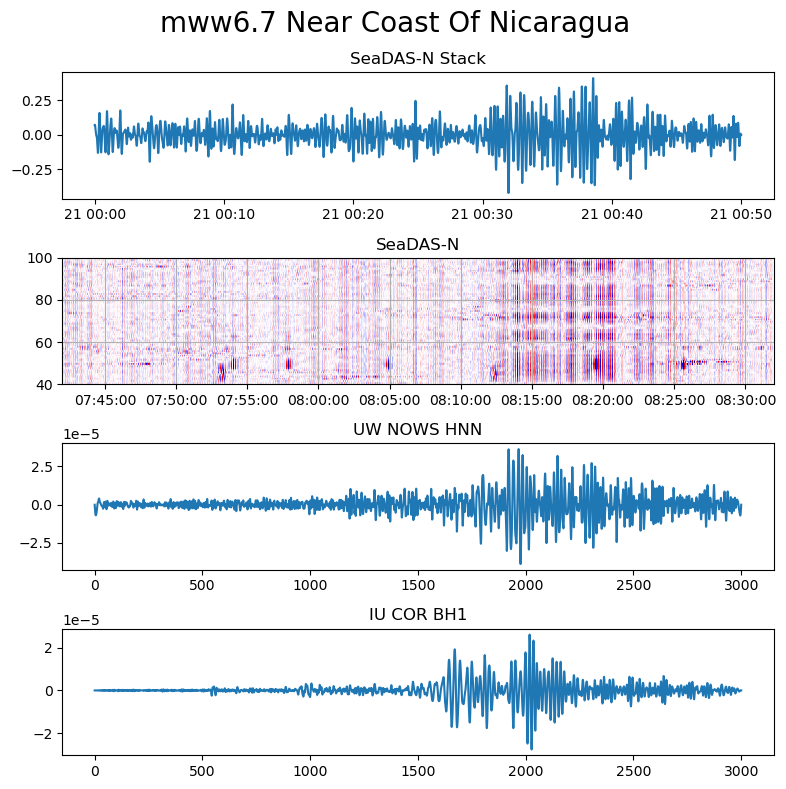

In [11]:

fig,ax=plt.subplots(figsize=(8,8))
plt.title(title)
ax = plt.subplot(4,1,1)

fig.patch.set_facecolor('w')
exx = np.mean(data_filt,axis=1)
t = np.array([time-time[0]]).flatten()/1e6
plt.plot(ptimes,exx)
ax.set_title('SeaDAS-N Stack')

ax=plt.subplot(4,1,2)
ax.set_title('SeaDAS-N')
plt.imshow(data_filt.T,vmin=-1,vmax=1,cmap='seismic',aspect='auto',
          extent=[dates[0],dates[-1],chmin,chanmax])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
plt.grid()

ax = plt.subplot(4,1,3)
for tr in st:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('UW NOWS HNN')

ax = plt.subplot(4,1,4)
for tr in st2:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('IU COR BH1')

fig.suptitle(title,fontsize=20)
plt.tight_layout()
plt.show()

# What if we stack only those with high xcorr?

Execution time is 20.982656
Channel with the strongest correlations: 21


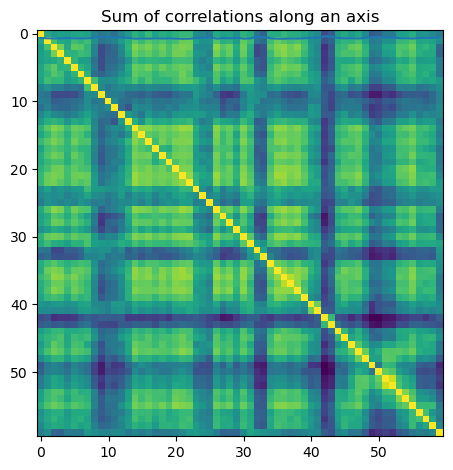

In [12]:
from time import perf_counter
nchan = chanmax - chmin

if nchan < 200: # at 200, takes 172s to run
    my_rho = np.zeros((nchan,nchan))
    pcounter_start = perf_counter()

    for j in range(nchan):
        for i in range(nchan):
            my_rho[i,j] = np.corrcoef(data_filt[:,j], data_filt[:,i])[0,1]
    pcounter_stop = perf_counter()        
    print('Execution time is %f'%(pcounter_stop-pcounter_start))
    mxc = np.argmax(np.sum(my_rho,axis=1))
    print('Channel with the strongest correlations: %d'%mxc)
    
    
    fig,ax=plt.subplots()
    plt.imshow(my_rho)
    ax.plot( np.mean(my_rho,axis=1) )
    ax.set_title('Sum of correlations along an axis')
    plt.tight_layout()
    plt.show()

    
else:
    print('Not calculating full xc matrix')
    mxc = 105
    my_rho = np.zeros((nchan,1))
    pcounter_start = perf_counter()

    for i in range(nchan):
        my_rho[i] = np.corrcoef(data_filt[:,64], data_filt[:,i])[0,1]
    pcounter_stop = perf_counter()        
    print('Execution time is %f'%(pcounter_stop-pcounter_start))

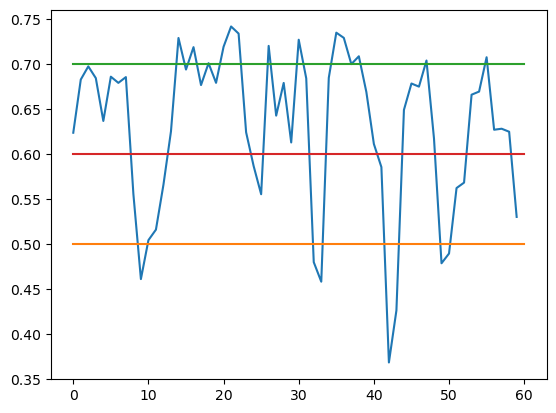

The Channel with the highest xcor: 21


In [13]:
fig,ax=plt.subplots()

ax.plot( np.average(my_rho,axis=1) )
# ax.set_ylim([0,0.25])
ax.plot([0,nchan],[0.5,0.5])
ax.plot([0,nchan],[0.7,0.7])
ax.plot([0,nchan],[0.6,0.6])
plt.show()
print('The Channel with the highest xcor: %d'%mxc)

In [27]:
data_filt_good_channels = data_filt[:,(np.mean(my_rho,axis=1) > 0.7).flatten()]
exx_cc = np.mean( data_filt_good_channels  ,axis=1)

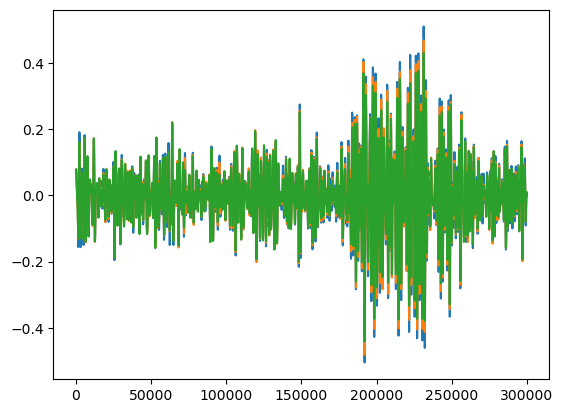

In [28]:
plt.subplots()
for thr in [0.7,0.6,0.5]:
    plt.plot(np.mean( data_filt[:,(np.mean(my_rho,axis=1) > thr).flatten()]  ,axis=1))
plt.show()

# Convert phase measurements to velocity

In [45]:
# Convert phase to strain
dphi = 0.2
nc = 1.468
xg = 10
psi = 0.79
lmbda = 1550e-9
factor = lmbda / 4/np.pi / nc/xg/psi * dphi
print(factor)

2.127152776467059e-09


In [50]:
# Integrate strain to get displacement
ux_all = factor * np.cumsum(data_filt_good_channels,axis=1) * xg
ux = factor * np.mean(np.cumsum(data_filt_good_channels,axis=1),axis=1) * xg

In [61]:
# Take time derivative of displacement to get velocity
tmax = 60*number_of_files
t_vec = np.linspace(0,tmax,len(ux))
dt = t_vec[1] - t_vec[0]
print(dt)
vx = np.gradient(ux, dt)
vx_all = np.gradient(ux_all, dt,axis=0)
vx_same = np.mean(vx_all,axis=1)

0.0100000666671


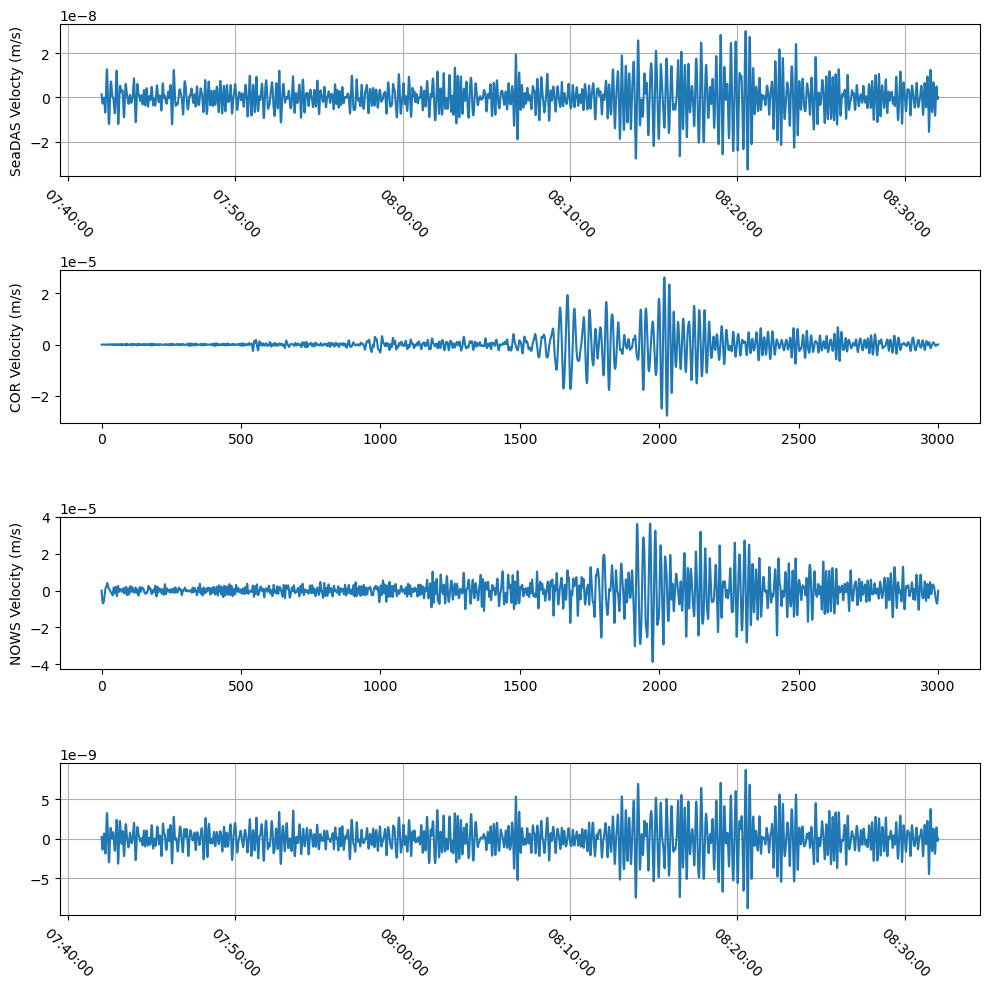

In [62]:
fig,axs = plt.subplots(3,1,figsize=(10,10))

ax = plt.subplot(4,1,1)
plt.plot(dates,vx)
plt.ylabel('SeaDAS Velocty (m/s)')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelrotation = -45)
plt.grid()

plt.subplot(4,1,2)
# plt.plot(exx_cc)
# plt.ylabel('Phase (unitless)')
for tr in st2:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
plt.ylabel('COR Velocity (m/s)')

plt.subplot(4,1,3)
for tr in st:
    plt.plot(tr.times(),tr.data)
plt.ylabel('NOWS Velocity (m/s)')

ax=plt.subplot(4,1,4)
ax.plot(dates,vx_all[:,1])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelrotation = -45)
plt.grid()

plt.tight_layout()
plt.show()

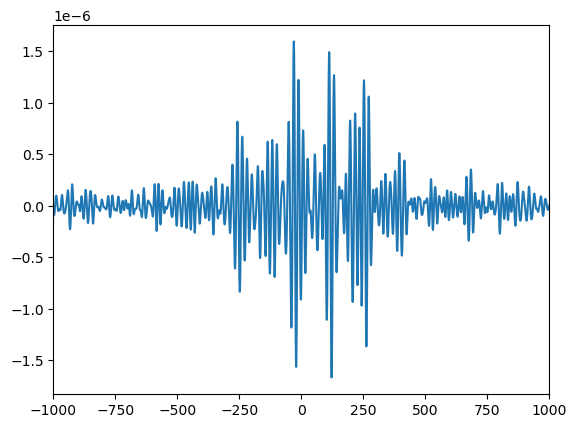

In [20]:
fig,ax=plt.subplots()
xc = np.correlate(st[0].data,st2[0].data,mode='full')
plt.plot(np.linspace(-3000,3000,len(xc)),xc)
plt.xlim((-1000,1000))
plt.show()